# Dataset Preparation

## Match T2-weighted images and labels

In [3]:
import os
import glob

image_dir = "picai_nifti"
label_dir = "picai_labels-main/anatomical_delineations/whole_gland/AI/Bosma22b"

# Load all T2W images
t2w_paths = sorted(glob.glob(os.path.join(image_dir, "*_t2w.nii.gz")))

data_dicts = []

for img_path in t2w_paths:
    # Extract patient_id and series_id from filename
    # Format: 10000_10000_1000000_t2w.nii.gz
    base = os.path.basename(img_path)
    parts = base.split("_")
    patient_id = parts[0]
    series_id = parts[2]

    label_name = f"{patient_id}_{series_id}.nii.gz"
    label_path = os.path.join(label_dir, label_name)

    if os.path.exists(label_path):
        data_dicts.append({
            "image": img_path,
            "label": label_path
        })

print(f"Loaded {len(data_dicts)} T2W-label pairs")

Loaded 300 T2W-label pairs


## Split into Training and Validation Sets

In [4]:
# Install scikit-learn library
!pip install scikit-learn

In [5]:
from sklearn.model_selection import train_test_split

# 80-20 split, with random seed for reproducibility
train_files, val_files = train_test_split(data_dicts, test_size=0.2, random_state=42)

print(f"Training samples: {len(train_files)}, Validation samples: {len(val_files)}")

Training samples: 240, Validation samples: 60


## Image Preprocessing

Sanity check to see if the file paths exist

In [26]:
for i, sample in enumerate(train_files[:3]):
    image_path = sample['image']
    label_path = sample['label']
    print(f"Sample {i}: Image exists? {os.path.exists(image_path)}; Label exists? {os.path.exists(label_path)}")

Sample 0: Image exists? True; Label exists? True
Sample 1: Image exists? True; Label exists? True
Sample 2: Image exists? True; Label exists? True


In [90]:
from monai.transforms import LoadImaged
import numpy as np

# Initialize the loader to get image only (you can add label if needed)
loader = LoadImaged(keys=["image", "label"])

# List to store depths
depths = []

# Loop through all training samples
for sample in train_files:
    loaded = loader(sample)
    image = loaded["image"]
    
    # Get the depth dimension (assumes shape is [C, H, W, D])
    depth = image.shape[-1]
    depths.append(depth)

# Convert to NumPy array for easy stats
depths = np.array(depths)

# Print stats
print(f"Number of training samples: {len(depths)}")
print(f"Min depth: {depths.min()}")
print(f"Max depth: {depths.max()}")
print(f"Average depth: {depths.mean():.2f}")

# Test loading the first sample
sample = train_files[0]
loaded_sample = loader(sample)

# Print the shapes of the loaded image and label
print(f"Image shape: {loaded_sample['image'].shape}")
print(f"Label shape: {loaded_sample['label'].shape}")

Number of training samples: 240
Min depth: 17
Max depth: 33
Average depth: 22.29
Image shape: torch.Size([384, 384, 21])
Label shape: torch.Size([384, 384, 21])


Perform a series of transforms:

In [51]:
from monai.transforms import ResizeD, Compose, LoadImaged, EnsureChannelFirstd, ScaleIntensityd, CropForegroundd, EnsureTyped

# Create a compose of transformations
train_transforms = Compose([
    LoadImaged(keys=["image", "label"]),
    EnsureChannelFirstd(keys=["image", "label"]),
    ScaleIntensityd(keys=["image", "label"]),
    CropForegroundd(keys=["image", "label"], source_key="image", allow_smaller=True),
    EnsureTyped(keys=["image", "label"]),
    ResizeD(keys=["image", "label"], spatial_size=(256, 256, 32), mode=["trilinear", "nearest"]) # Specify trilinear interpolation for resizing images for smoothness; nearest to preserve binary values for labels.
])

# Apply the transforms to the first sample
sample = train_files[0]  # or your dataset
transformed_sample = train_transforms(sample)

image_tensor = transformed_sample['image'].detach().clone().requires_grad_(True)
label_tensor = transformed_sample['label'].detach().clone().requires_grad_(True)

transformed_sample = {
    "image": image_tensor,  # (1, H, W, D) tensor
    "label": label_tensor   # (1, H, W, D) tensor
}

# Check the transformed shapes
print(f"Transformed image shape: {transformed_sample['image'].shape}")
print(f"Transformed label shape: {transformed_sample['label'].shape}")
print(torch.unique(label_tensor))

Transformed image shape: torch.Size([1, 256, 256, 32])
Transformed label shape: torch.Size([1, 256, 256, 32])
metatensor([0., 1.], grad_fn=<AliasBackward0>)


Load Data:

LoadImaged loads 3D images and labels locally into a dictionary.

Ensure Correct Channel Order:

EnsureChannelFirstd ensures that the channel dimension comes first for proper model input (Greyscale = 1).

Intensity Normalization:

ScaleIntensityd scales image pixel intensities to the [0, 1] range for numerical stability during training.

Crop Background:

CropForegroundd crops the image and label to remove unnecessary background, focusing on the region of interest (ROI).

Ensure Correct Data Type:

EnsureTyped ensures that the image and label are converted to the correct data type, like torch.Tensor, for deep learning models.

ResizeD:

Resize all images so they fit into training and validation tensors with tensor structure (Greyscale channel 0/1, Height, Width, Depth) to 256X256X32 to standardize input and reduce memory without losing spatial structure. Depth choice is a power of 2, safe upper-bound padding, and compatible with most 3D UNets.


### Visualize a random 3D T2W image

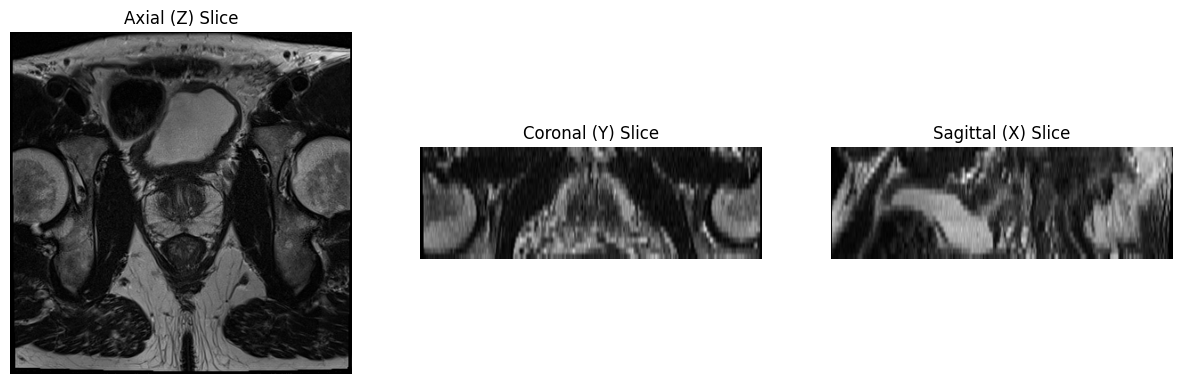

In [45]:
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk

# Load the 3D image and get real voxel spacing
image_path = 'picai_nifti/11138_11138_1001161_t2w.nii.gz'
image = sitk.ReadImage(image_path)
spacing = image.GetSpacing() # (x_spacing, y_spacing, z_spacing)
image_array = sitk.GetArrayFromImage(image)  # shape: (z, y, x)

# Convert spacing to match numpy shape (z, y, x)
# Sitk spacing is (x, y, z), need to reverse
spacing = spacing[::-1]  # Now spacing = (z_spacing, y_spacing, x_spacing)

# Extract image shape
z_dim, y_dim, x_dim = image_array.shape
z_spacing, y_spacing, x_spacing = spacing

def plot_3d_slices_with_spacing(image_array, spacing):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Axial view (slice through z-axis, show y vs x)
    axes[0].imshow(image_array[z_dim // 2, :, :], cmap='gray', 
                   aspect=y_spacing / x_spacing)
    axes[0].set_title('Axial (Z) Slice')
    axes[0].axis('off')

    # Coronal view (slice through y-axis, show z vs x)
    axes[1].imshow(image_array[:, y_dim // 2, :], cmap='gray', 
                   aspect=z_spacing / x_spacing)
    axes[1].set_title('Coronal (Y) Slice')
    axes[1].axis('off')

    # Sagittal view (slice through x-axis, show z vs y)
    axes[2].imshow(image_array[:, :, x_dim // 2], cmap='gray', 
                   aspect=z_spacing / y_spacing)
    axes[2].set_title('Sagittal (X) Slice')
    axes[2].axis('off')

    plt.show()

plot_3d_slices_with_spacing(image_array, spacing)

### Apply transforms to training and validation sets

In [135]:
from monai.data import Dataset, DataLoader

train_ds = Dataset(data=train_files, transform=train_transforms)
val_ds = Dataset(data=val_files, transform=train_transforms)

# specify batch size of 2 in training and validation. Memory-efficient for 3D medical data
train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, num_workers=4)
val_loader = DataLoader(val_ds, batch_size=4, shuffle=False, num_workers=4)

## Save transformed images

In [47]:
import pickle
import torch

# Save file lists
with open("train_files.pkl", "wb") as f:
    pickle.dump(train_files, f)

with open("val_files.pkl", "wb") as f:
    pickle.dump(val_files, f)

# Save transforms
torch.save(train_transforms, "train_transforms.pt")

## Train a 3D U-net

In [ ]:
!pip install pytorch-ignite

Choice of learning rate:
From experience, a good starting point that works well for training convolutional networks like U-Net, especially when using the Adam optimizer, which adapts learning rates internally. Doesn't cause the model to diverge (too high) and doesn't learn too slowly for medical datasets which are relatively small. Then adjust learning rate adaptively using the Cosine Annealing scheduler.

U-net architecture:
Number of strides (2, 2, 2) = 3 levels of downsampling steps = 3 depth.
1 input block (channels = 32) and one probability output with sigmoid layer to generate labels.

In [182]:
import os
import time
import torch
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
import matplotlib.pyplot as plt
from monai.networks.nets import UNet
from monai.losses import DiceLoss
from monai.losses import DiceCELoss
from monai.metrics import DiceMetric
from monai.engines import SupervisedTrainer
from ignite.engine import Engine, events

# Try to use Mac GPU on M2 Pro chip (MPS)
device = torch.device("cpu")  # or "mps" if MPS is available on Mac

# Directory to save checkpoints
checkpoint_dir = "checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

# Specify a 3D U-net
model = UNet(
    spatial_dims=3,            # 3D U-Net
    in_channels=1,             # One input channel (e.g., grayscale image)
    out_channels=1,            # One output channel (e.g., binary mask)
    channels=(32, 64, 128, 256),  # Feature maps at each level
    strides=(2, 2, 2),      # 3 downsamples is depth=3
    num_res_units=2            # Number of residual units per stage
).to(device)

# Dice loss function to minimize difference between ground truth and predicted masks. Added cross-entropy to learn quicker.
loss_fn = DiceCELoss(sigmoid=True) # sigmoid to binarize probabilities to labels
optimizer = torch.optim.Adam(model.parameters(), lr=4e-4)
num_epochs = 20
scheduler = CosineAnnealingLR(optimizer, T_max=20)

# Training loop setup
def train_step(engine, batch):
    model.train()
    inputs, labels = batch["image"].to(device), batch["label"].to(device)
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = loss_fn(outputs, labels)
    loss.backward()
    optimizer.step()
    return loss.item()

# Track per-epoch loss and dice score
epoch_losses = []
epoch_dice_scores = []

trainer = Engine(train_step)

# Event triggered at the start of every epoch
@trainer.on(Events.EPOCH_STARTED)
def start_epoch(engine):
    engine.state.epoch_loss_total = 0.0
    engine.state.epoch_loss_count = 0

@trainer.on(Events.ITERATION_COMPLETED)
def collect_iteration_loss(engine):
    # Get the loss from the current iteration
    loss = engine.state.output
    if isinstance(loss, torch.Tensor):
        loss = loss.item() # Convert tensor to scalar
    
    # Accumulate total loss and count the number of iterations (batches)
    engine.state.epoch_loss_total += loss
    engine.state.epoch_loss_count += 1

# Event triggered after every training iteration (i.e., one batch update)
@trainer.on(Events.EPOCH_COMPLETED)
def compute_epoch_loss_and_save(engine):
    epoch = engine.state.epoch

    # Compute the average loss for this epoch
    if engine.state.epoch_loss_count > 0:
        avg_loss = engine.state.epoch_loss_total / engine.state.epoch_loss_count
        epoch_losses.append(avg_loss)
        print(f"Epoch {epoch}: Average Loss = {avg_loss:.4f}")
    else:
        avg_loss = None
        print(f"Epoch {epoch}: No loss data collected.")

    # Save checkpoint
    checkpoint_path = os.path.join(checkpoint_dir, f"checkpoint_epoch_{epoch}.pt")
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': avg_loss,
    }, checkpoint_path)
    print(f"✅ Saved checkpoint: {checkpoint_path}")

    # Step the LR scheduler
    scheduler.step()
    print(f"Epoch {epoch+1}/{num_epochs} - LR: {scheduler.get_last_lr()[0]:.6f}")

# Dice metric for training
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)

# Setup the training scheme for real-time dice score calculation
@trainer.on(Events.EPOCH_COMPLETED)
def compute_training_dice(engine):
    model.eval()
    dice_metric.reset()
    with torch.no_grad():
        for batch in train_loader:
            images = batch["image"].to(device)
            labels = batch["label"].to(device)

            outputs = model(images)
            outputs = (outputs > 0.5).float()  # threshold to binary

            dice_metric(y_pred=outputs, y=labels)

    epoch_dice = dice_metric.aggregate().item()
    epoch_dice_scores.append(epoch_dice)
    print(f"Epoch {engine.state.epoch} Training Dice Score: {epoch_dice:.4f}")
    dice_metric.reset()

# Start training
start_time = time.time()
trainer.run(train_loader, max_epochs=20)
end_time = time.time()
elapsed = end_time - start_time

print(f"Training completed in {elapsed:.2f} seconds ({elapsed / 60:.2f} minutes).")

Epoch 1: Average Loss = 1.6983
✅ Saved checkpoint: checkpoints/checkpoint_epoch_1.pt
Epoch 2/20 - LR: 0.000398
Epoch 1 Training Dice Score: 0.0025
Epoch 2: Average Loss = 1.6505
✅ Saved checkpoint: checkpoints/checkpoint_epoch_2.pt
Epoch 3/20 - LR: 0.000390
Epoch 2 Training Dice Score: 0.5493
Epoch 3: Average Loss = 1.6128
✅ Saved checkpoint: checkpoints/checkpoint_epoch_3.pt
Epoch 4/20 - LR: 0.000378
Epoch 3 Training Dice Score: 0.7240
Epoch 4: Average Loss = 1.5921
✅ Saved checkpoint: checkpoints/checkpoint_epoch_4.pt
Epoch 5/20 - LR: 0.000362
Epoch 4 Training Dice Score: 0.7376
Epoch 5: Average Loss = 1.5698
✅ Saved checkpoint: checkpoints/checkpoint_epoch_5.pt
Epoch 6/20 - LR: 0.000341
Epoch 5 Training Dice Score: 0.7779
Epoch 6: Average Loss = 1.5503
✅ Saved checkpoint: checkpoints/checkpoint_epoch_6.pt
Epoch 7/20 - LR: 0.000318
Epoch 6 Training Dice Score: 0.8021
Epoch 7: Average Loss = 1.5311
✅ Saved checkpoint: checkpoints/checkpoint_epoch_7.pt
Epoch 8/20 - LR: 0.000291
Epoch 7

In [193]:
# Save full model
torch.save(model, "trained_model.pth")
print("✅ Full model saved as 'trained_model.pth'")

# Save model weights
torch.save(model.state_dict(), "trained_model_weights.pth")
print("✅ Model weights saved as 'trained_model_weights.pth'")

✅ Full model saved as 'trained_model.pth'
✅ Model weights saved as 'trained_model_weights.pth'


### Resume training if stopped at checkpoint

In [ ]:
checkpoint = torch.load("checkpoints/checkpoint_epoch_9.pt", map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
scheduler.load_state_dict(checkpoint['scheduler_state_dict'])  # optional
start_epoch = checkpoint['epoch'] + 1

### Visualize U-net Architecture

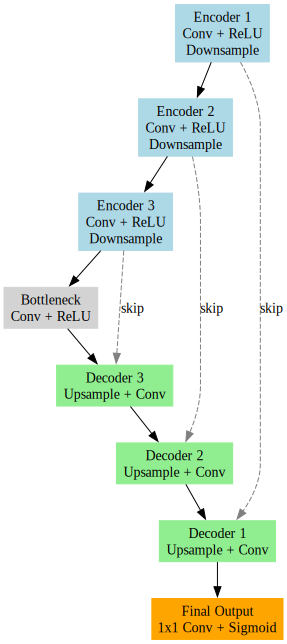

In [186]:
from graphviz import Digraph
from IPython.display import SVG, display

def create_unet_graph_svg():
    g = Digraph('UNet', format='svg')
    g.attr(rankdir='TB', splines='spline')  # Top to Bottom U-shape

    depth = 3  # Number of downsampling/upsampling steps

    # Contracting path (Encoder)
    for i in range(depth):
        g.node(f"enc{i}", f"Encoder {i+1}\nConv + ReLU\nDownsample", shape='box', style='filled', color='lightblue')

    # Bottleneck
    g.node("bottleneck", "Bottleneck\nConv + ReLU", shape='box', style='filled', color='lightgrey')

    # Expanding path (Decoder)
    for i in range(depth):
        g.node(f"dec{i}", f"Decoder {depth-i}\nUpsample + Conv", shape='box', style='filled', color='lightgreen')

    # Encoder path connections
    for i in range(depth):
        g.edge(f"enc{i}", f"bottleneck" if i == depth - 1 else f"enc{i+1}")

    # Decoder path connections
    for i in range(depth):
        if i == 0:
            g.edge("bottleneck", "dec0")
        else:
            g.edge(f"dec{i-1}", f"dec{i}")

        # Skip connections
        g.edge(f"enc{depth-1-i}", f"dec{i}", style='dashed', color='gray', label="skip")

    # Output
    g.node("output", "Final Output\n1x1 Conv + Sigmoid", shape='box', style='filled', color='orange')
    g.edge(f"dec{depth - 1}", "output")

    output_path = g.render('unet_architecture', cleanup=True)
    return output_path

# Display the SVG
svg_path = create_unet_graph_svg()
display(SVG(filename=svg_path))

### Plot training loss

In [ ]:
!pip install graphviz matplotlib

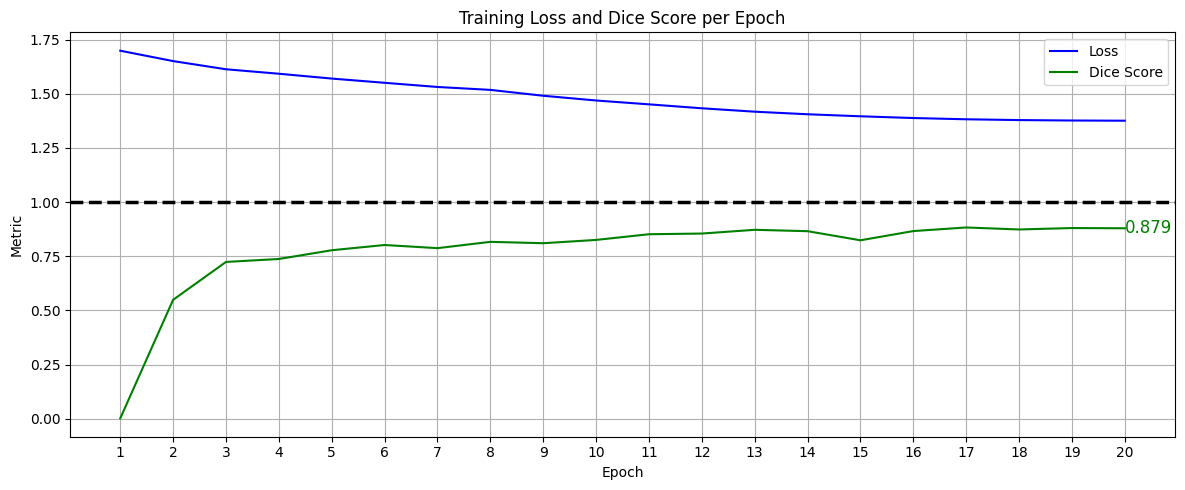

In [191]:
plt.figure(figsize=(12, 5))
plt.plot(range(1, num_epochs + 1), epoch_losses, label="Loss", color='blue')
plt.plot(range(1, num_epochs + 1), epoch_dice_scores, label="Dice Score", color='green')
plt.axhline(y=1, color='black', linestyle='--', linewidth=2.5)  # thick black dotted line

# annotate final dice score
last_dice = epoch_dice_scores[-1]
plt.text(num_epochs, last_dice, f"{last_dice:.3f}", color='green', fontsize=12, ha='left', va='center')

plt.xlabel("Epoch")
plt.ylabel("Metric")
plt.title("Training Loss and Dice Score per Epoch")
plt.xticks(range(1, num_epochs + 1))
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig("training_metrics.png", dpi=300)
plt.show()

## Validating the Segmentation Classifier

### Evaluating Performance on the Validation Set

In [192]:
from monai.metrics import DiceMetric

# Put model in evaluation mode
model.eval()

# Initialize metric and reset before starting
dice_metric = DiceMetric(include_background=True, reduction="mean")
dice_metric.reset()

# Disable gradient computation for evaluation
with torch.no_grad():
    for val_data in val_loader:
        val_images = val_data["image"].to(device)
        val_labels = val_data["label"].to(device)

        # Forward pass
        val_outputs = model(val_images)

        # Apply sigmoid and threshold for binary prediction
        val_outputs = torch.sigmoid(val_outputs)
        val_outputs = (val_outputs > 0.5).float()

        # Add to Dice metric
        dice_metric(y_pred=val_outputs, y=val_labels)

# Compute final Dice score
dice_score = dice_metric.aggregate().item()
print(f"Validation Dice Score: {dice_score:.4f}")

Validation Dice Score: 0.8430


### Visualize a prediction against the ground truth

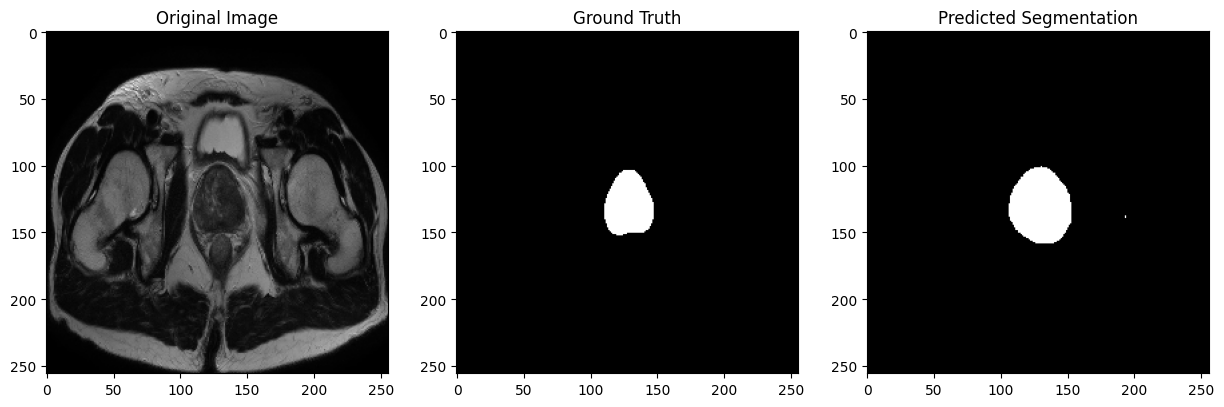

In [206]:
sample_pred = val_outputs[0, 0].cpu().numpy()
sample_label = val_labels[0, 0].cpu().numpy()

# Rotate each 2D slice 90 degrees clockwise (they are originally sideways)
img_slice = np.rot90(sample_image[:, :, sample_image.shape[2]//2], k=-1)
label_slice = np.rot90(sample_label[:, :, sample_label.shape[2]//2], k=-1)
pred_slice = np.rot90(sample_pred[:, :, sample_pred.shape[2]//2], k=-1)

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(img_slice, cmap="gray")
plt.title("Original Image")

plt.subplot(1, 3, 2)
plt.imshow(label_slice, cmap="gray")
plt.title("Ground Truth")

plt.subplot(1, 3, 3)
plt.imshow(pred_slice, cmap="gray")
plt.title("Predicted Segmentation")

plt.savefig("predicted_mask.png", dpi=300)
plt.show()

### Computing Dice Prediction Variance in Validation

This is important to get more insight into the distribution of segmentation performance on each patient. We ideally want a low variance in the dice scores across all the patients in the validation set such that the probability of the next unseen patient is close to the mean dice score.

In [204]:
import numpy as np
from monai.metrics import DiceMetric

# Initialize DiceMetric for per-patient Dice scores
dice_metric = DiceMetric(include_background=True, reduction="none")  # "none" returns Dice per patient

dice_scores_per_patient = []

model.eval()
with torch.no_grad():
    for batch in val_loader:
        images = batch["image"].to(device)
        labels = batch["label"].to(device)

        outputs = model(images)
        outputs = (outputs > 0.5).float()  # Binarize predictions

        # Compute Dice scores for this batch (per sample)
        dice_values = dice_metric(y_pred=outputs, y=labels)  # shape: (batch_size,)
        dice_scores_per_patient.extend(dice_values.cpu().numpy().flatten())

# Convert to NumPy array
dice_scores_per_patient = np.array(dice_scores_per_patient)

# Compute statistics
min_dice = np.min(dice_scores_per_patient)
max_dice = np.max(dice_scores_per_patient)
variance_dice = np.var(dice_scores_per_patient)
std_dice = np.std(dice_scores_per_patient)
print(f"Min Dice: {min_dice:.4f}")
print(f"Max Dice: {max_dice:.4f}")
print(f"Variance: {variance_dice:.4f}")
print(f"Standard Deviation: {std_dice:.4f}")

Min Dice: 0.7331
Max Dice: 0.9420
Variance: 0.0025
Standard Deviation: 0.0495


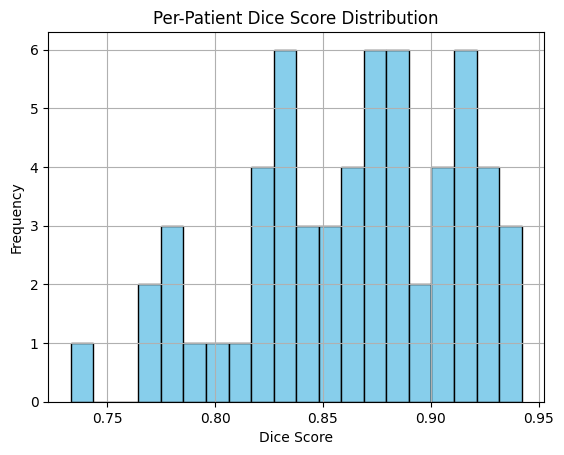

In [203]:
plt.hist(dice_scores_per_patient, bins=20, color='skyblue', edgecolor='black')
plt.title("Per-Patient Dice Score Distribution")
plt.xlabel("Dice Score")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

Since variance is quite low, most predictions are close to the validation mean (0.84). More specifically, the standard deviation is ~0.05, thus 68% of predictions fall between 0.79 and 0.89. The worst prediction is 0.73, which only occured 1/60 times. The distribution is evidently left-skewed and has two modes beyond the mean, which has a more positive outlook than a right-skewed distribution when considering the probability of a high dice score for the next unseen patient.